In [31]:
import fitz
from pathlib import Path
import random

import pandas as pd 
import numpy as np

from tqdm.autonotebook import tqdm, trange

import torch

In [2]:
pdf_path = Path('./Early Iran History.pdf')
doc = fitz.open(pdf_path)

In [3]:
page_content = {}
for page_number, page in enumerate(doc) :
    text = page.get_text()#.replace('\n', ' ')
    page_content[page_number+1] = text

In [4]:
data = pd.DataFrame(columns=['page_number', 'text'])
data['page_number'] = list(page_content.keys())
data['text'] = list(page_content.values())

In [5]:
data.apply(
    lambda row: [
        len(row['text']),            # char count
        len(row['text'].split()),    # word count
        len(row['text'].split('. ')) # sentence count
    ],
    axis=1,
)

0          [57, 19, 1]
1         [282, 60, 1]
2         [250, 37, 2]
3         [262, 86, 3]
4           [28, 4, 1]
            ...       
273    [1770, 301, 15]
274     [1657, 263, 3]
275     [1672, 276, 8]
276    [1649, 278, 15]
277     [1351, 225, 7]
Length: 278, dtype: object

In [6]:

data[['char_count', 'word_count', 'sentence_count']] = data.apply(
    lambda row: [
        len(row['text']),            # char count
        len(row['text'].split()),    # word count
        len(row['text'].split('. ')) # sentence count
    ],
    axis=1,
    result_type='expand',
)

In [7]:
data['token_count'] = data['char_count'] / 4 # assuming 4 chars per token

In [8]:
data

,page_number,text,char_count,word_count,sentence_count,token_count
0,1,H I S T O R Y O F E A R L Y I R A N \noi.u...,57,19,1,14.25
1,2,T H E U N I V E R S I T Y O F C H I C A G O...,282,60,1,70.50
2,3,HISTORY OF EARLY IRAN \nBY GEORGE G. CAMERON \...,250,37,2,62.50
3,4,C O P Y R I G H T I 9 3 6 B Y T H E U N I ...,262,86,3,65.50
4,5,TO MY WIFE \noi.uchicago.edu\n,28,4,1,7.00
...,...,...,...,...,...,...
273,274,"256 \nHISTORY OF EARLY IRAN \nSikris, c., 151 ...",1770,301,15,442.50
274,275,"INDEX \nSusa, c.—Continued \npottery of, 8-10 ...",1657,263,3,414.25
275,276,"258 \nHISTORY OF EARLY IRAN \nTetep-mada, p.y ...",1672,276,8,418.00
276,277,"INDEX \n259 \nUmhuluma, p. y 199, 204 \nUmma,...",1649,278,15,412.25


In [9]:
data.describe()

,page_number,char_count,word_count,sentence_count,token_count
count,278.000000,278.000000,278.000000,278.000000,278.000000
mean,139.500000,1552.615108,254.305755,17.050360,388.153777
std,80.395895,353.851760,61.606033,8.775848,88.462940
min,1.000000,16.000000,1.000000,1.000000,4.000000
25%,70.250000,1524.250000,249.000000,12.000000,381.062500
50%,139.500000,1615.500000,265.000000,16.000000,403.875000
75%,208.750000,1718.750000,284.000000,21.000000,429.687500
max,278.000000,2386.000000,396.000000,78.000000,596.500000


<Axes: ylabel='Frequency'>

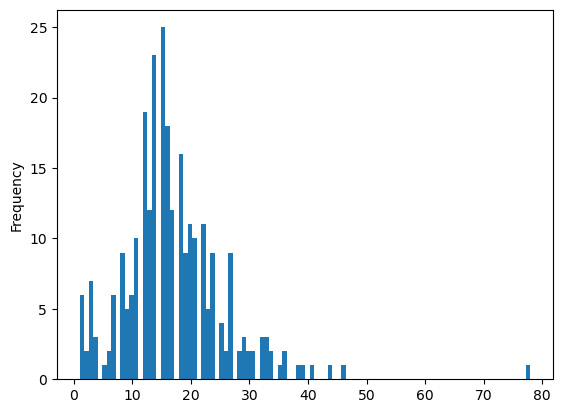

In [10]:
data['sentence_count'].plot(kind='hist', bins=100)

<Axes: ylabel='Frequency'>

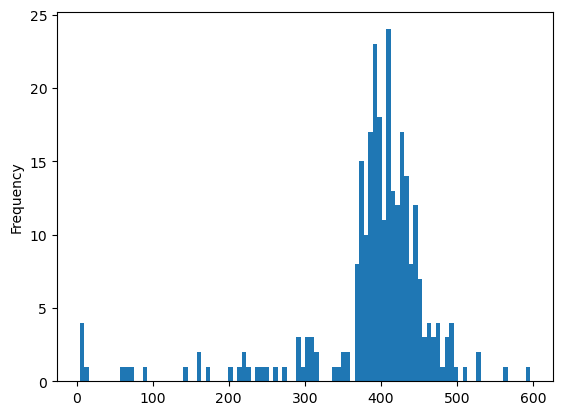

In [11]:
data['token_count'].plot(kind='hist', bins=100)

___

In [12]:
# import os
# os.environ['HF_HOME'] = '~/huggingface_cache'
# os.environ['TRANSFORMERS_CACHE'] = '~/huggingface_cache'

### splitting pages into sentences

In [13]:
from spacy.lang.en import English 

In [14]:
nlp = English()
nlp.add_pipe("sentencizer")

In [15]:
data['sentences'] = data.apply(
    func=lambda row: list(nlp(row['text']).sents),
    axis=1,
    # result_type='expand'
)

In [61]:
sample = data.sample()
sample

,page_number,text,char_count,word_count,sentence_count,token_count,sentences
76,77,"BABYLONIAN DYNASTS \n61 \nKindattu, as king of...",2039,332,29,509.75,"[(BABYLONIAN, DYNASTS, \n, 61, \n, Kindattu, ,..."


In [66]:
data.describe().round(2)

,page_number,char_count,word_count,sentence_count,token_count
count,278.00,278.00,278.00,278.00,278.00
mean,139.50,1552.62,254.31,17.05,388.15
std,80.40,353.85,61.61,8.78,88.46
min,1.00,16.00,1.00,1.00,4.00
25%,70.25,1524.25,249.00,12.00,381.06
50%,139.50,1615.50,265.00,16.00,403.88
75%,208.75,1718.75,284.00,21.00,429.69
max,278.00,2386.00,396.00,78.00,596.50


### Chunking our sentences together